# Topic Modeling: Latent Dirichlet Allocation (LDA) 

# 1. Import libraries

In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
import string
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import wordnet

# Gensim
import gensim, spacy, logging, warnings

#This module implements the concept of a Dictionary – a mapping between words and their integer ids.
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess 

#from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
newStopWords = ['thank', 'benefit', 'thing', 'americanexpress' 'the', 'credit', 'replying', 'to', 'one', 'like', 'used', 'see','american','express','amex','company', 'card', 'business', 'year', 'many', 'point', 'use', 'item']
STOPWORDS.extend(newStopWords)

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


# 2. Import dataset

In [2]:
df = pd.read_excel('pos_reviews.xlsx')
df.head()

,source,review,neg,neu,pos,compound
0,Amex_Delta_Gold,Time is of the essence in business and handlin...,0.079,0.719,0.202,0.5562
1,Amex_Delta_Gold,We (my wife & I) both have a card in our own n...,0.018,0.711,0.272,0.9638
2,Amex_Delta_Plat,I used my Delta Amex as my primary credit card...,0.000,0.685,0.315,0.9080
3,Amex_Delta_Plat,I have been using Amex Delta Skymiles card for...,0.016,0.757,0.227,0.9774
4,Amex_Delta_Reserve,I love my American Express card. I use the poi...,0.000,0.664,0.336,0.9210


In [3]:
df.shape

(709, 6)

# 3. Removing words starting with @

In [4]:
new_rev = []
for text in df['review']:
    new_rev.append(" ".join(filter(lambda x:x[0]!='@', text.split())))
df['cleaned review'] = new_rev

# 4. Function for data cleaning

In [5]:
def clean_text(text):
    # lower text
    text = text.lower()
    
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # remove stop words
    STOPWORDS = stopwords.words('english')
    newStopWords = ['thank', 'benefit', 'thing', 'americanexpress' 'the', 'credit', 'replying', 'to', 'one', 'like', 'used', 'see','american','express','amex','company', 'card', 'business', 'year', 'many', 'point', 'use', 'item']
    STOPWORDS.extend(newStopWords)
    text = [x for x in text if x not in STOPWORDS]
    
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    
    # remove words with two letter
    text = [t for t in text if len(t) > 2]
    #bug = [t for t in text if len(t) <= 2]
    #print(bug)
    # join all
    text = " ".join(text)
    
    return(text)

In [6]:
df["cleaned review"] = df["cleaned review"].apply(lambda x: clean_text(x))

In [7]:
# Add number of characters column
df["n_chars"] = df["review"].apply(lambda x: len(x))

# Add number of words column
df["n_words"] = df["review"].apply(lambda x: len(x.split(" ")))

# 5. Tokenize and clean reviews

In [8]:
# simple_preprocess converts a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) #deacc (bool, optional) – Remove accent marks from tokens using deaccent()
        yield(sent)  

# Convert to list
data = df['review']
data_words = list(sent_to_words(data))
print(data_words[:1])

[['time', 'is', 'of', 'the', 'essence', 'in', 'business', 'and', 'handling', 'monetary', 'transactions', 'quickly', 'and', 'professionaly', 'is', 'critical', 'with', 'small', 'consulting', 'business', 'thanks', 'for', 'the', 'support']]


# 6. Build the Bigram, Trigram Models and Lemmatize

Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, **keeping only nouns, adjectives, verbs and adverbs.**

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [9]:
import en_core_web_sm 
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

#### Biagram
* **min_count** ignore all words and bigrams with total collected count lower than this. Bydefault it value is 5

* **threshold** represents a threshold for forming the phrases (higher means fewer phrases). A phrase of words a and b is accepted if (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold, where N is the total vocabulary size. Bydefault it value is 10.0

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=STOPWORDS, allowed_postags=['NOUN']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts_out]    
    return texts_out

# processed Text Data!
data_ready = process_words(data_words) 

In [11]:
bigram_mod.phrasegrams
#trigram_mod.phrasegrams

{(b'credit', b'card'): 11.032048518659398,
 (b'easy', b'to'): 15.285865466020164,
 (b'highly', b'recommend'): 106.66447368421052,
 (b'this', b'card'): 10.235733207892848,
 (b'have', b'been'): 15.03431008902077,
 (b'delta', b'skymiles'): 163.7676767676768,
 (b'long', b'time'): 18.984777517564403,
 (b'customer', b'service'): 67.08601897328938,
 (b'has', b'been'): 16.213,
 (b'thank', b'you'): 30.087751855779427,
 (b'american', b'express'): 103.8155344063857,
 (b'rewards', b'program'): 30.59056603773585,
 (b'gift', b'cards'): 50.24690082644628,
 (b'years', b'ago'): 29.003577817531305,
 (b'very', b'helpful'): 11.877655677655678,
 (b'they', b'are'): 13.050290473857352,
 (b'if', b'you'): 21.469542990884456,
 (b'annual', b'fee'): 140.6889968760847,
 (b'one', b'of'): 10.533393970893972,
 (b'trying', b'to'): 12.08122205663189,
 (b'very', b'good'): 11.012395992528443,
 (b'always', b'been'): 11.104794520547946,
 (b'able', b'to'): 17.71912568306011,
 (b'my', b'favorite'): 29.798329156223893,
 (b'wi

In [12]:
data_ready[3]

['delta_skymile',
 'mile',
 'travel',
 'service',
 'satisfie',
 'expense',
 'process',
 'query',
 'relating',
 'charge',
 'phone',
 'reception',
 'family',
 'vacation',
 'family',
 'trip',
 'rest',
 'family',
 'time',
 'upgrade',
 'focus',
 'job',
 'catch',
 'paperwork',
 'flight',
 'crew',
 'smile',
 'departure']

# 7. Build the LDA Topic Model

To build the LDA topic model using LdaModel(), you need the **corpus and the dictionary.** Let’s create them first and then build the model. 

* In order to work on text documents, Gensim requires the words (aka tokens) be converted to unique ids. In order to achieve that, Gensim lets you create a **Dictionary object that maps each word to a unique id**. You can create a `Dictionary` By converting your text/sentences to a list of words and pass it to the corpora.Dictionary() object.



* A ‘token’ typically means a ‘word’. A ‘document’ can typically refer to a ‘sentence’ or ‘paragraph’ and a ‘corpus’ is typically a ‘collection of documents as a bag of words’. That is, for each document, **a corpus contains each word’s id and its frequency count in that document.** As a result, information of the order of words is lost.

#### doc2bow
Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

#### Parameters of LDA model
* **corpus** ({iterable of list of (int, float), scipy.sparse.csc}, optional) – Stream of document vectors or sparse matrix of shape (num_terms, num_documents). If not given, the model is left untrained (presumably because you want to call update() manually).

* **num_topics** (int, optional) – The number of requested latent topics to be extracted from the training corpus.

* **id2word** ({dict of (int, str), gensim.corpora.dictionary.Dictionary}) – Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.

* **distributed** (bool, optional) – Whether distributed computing should be used to accelerate training.

* **chunksize** (int, optional) – Number of documents to be used in each training chunk.

* **passes** (int, optional) – Number of passes through the corpus during training. Passes are not related to chunksize or update_every. Passes is the number of times you want to go through the entire corpus.

* **update_every** (int, optional) – Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning.

* **alpha** ({numpy.ndarray, str}, optional) –
Can be set to an 1D array of length equal to the number of expected topics that expresses our a-priori belief for the each topics’ probability. Alternatively default prior selecting strategies can be employed by supplying a string:

    ’asymmetric’: Uses a fixed normalized asymmetric prior of 1.0 / topicno.

    ’auto’: Learns an asymmetric prior from the corpus (not available if distributed==True).

* **decay** (float, optional) – A number between (0.5, 1] to weight what percentage of the previous lambda value is forgotten when each new document is examined. Corresponds to Kappa from Matthew D. Hoffman, David M. Blei, Francis Bach: “Online Learning for Latent Dirichlet Allocation NIPS’10”.

* **iterations** (int, optional) – Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.

* **gamma_threshold** (float, optional) – Minimum change in the value of the gamma parameters to continue iterating.

* **random_state** ({np.random.RandomState, int}, optional) – Either a randomState object or a seed to generate one. Useful for reproducibility.

* **per_word_topics** (bool) – If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word, along with their phi values multiplied by the feature length (i.e. word count).

* **minimum_phi_value** (float, optional) – if per_word_topics is True, this represents a lower bound on the term probabilities.





In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=500,
                                           alpha='symmetric',
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.046*"month" + 0.038*"love" + 0.029*"gold" + 0.028*"app" + 0.027*"website" '
  '+ 0.021*"offer" + 0.019*"place" + 0.014*"way" + 0.013*"access" + '
  '0.013*"problem"'),
 (1,
  '0.085*"reward" + 0.076*"gold" + 0.054*"customer" + 0.041*"bonus" + '
  '0.036*"purchase" + 0.034*"issue" + 0.028*"perk" + 0.028*"fee" + '
  '0.024*"payment" + 0.019*"team"'),
 (2,
  '0.048*"time" + 0.039*"account" + 0.039*"travel" + 0.035*"gold" + '
  '0.035*"help" + 0.023*"people" + 0.023*"score" + 0.021*"lot" + 0.021*"limit" '
  '+ 0.021*"pay"'),
 (3,
  '0.053*"service" + 0.048*"platinum" + 0.024*"charge" + 0.024*"product" + '
  '0.022*"day" + 0.020*"money" + 0.018*"interest" + 0.018*"guy" + 0.016*"cash" '
  '+ 0.015*"balance"')]


In [36]:
#id2word.get(123)


# 8. What is the Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [37]:
# for i, row_list in enumerate(lda_model[corpus]):
#     #pprint (row_list)
#     row = row_list[0] if lda_model.per_word_topics else row_list  
#     row = sorted(row, key=lambda x: (x[1]), reverse=True)
#     pprint(row)
    

In [38]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
       # print(i, row_list)
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                #pprint(wp)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.6799,"month, love, gold, app, website, offer, place, way, access, problem","[time, essence, transaction, professionaly, consulting]"
1,1,0.0,0.5969,"month, love, gold, app, website, offer, place, way, access, problem","[bag, boarding, way, flight, wife, love, travel, award, loyalty]"
2,2,0.0,0.5636,"month, love, gold, app, website, offer, place, way, access, problem","[app, transaction, history]"
3,3,2.0,0.6830,"time, account, travel, gold, help, people, score, lot, limit, pay","[delta_skymile, mile, travel, service, satisfie, expense, process, query, relating, charge, phone, reception, family, vacation, family, trip, rest, family, time, upgrade, focus, job, catch, paperwork, flight, crew, smile, departure]"
4,4,1.0,0.5065,"reward, gold, customer, bonus, purchase, issue, perk, fee, payment, team","[love, family, airline, work, customer, support, prompt]"
5,5,1.0,0.6250,"reward, gold, customer, bonus, purchase, issue, perk, fee, payment, team",[perk]
6,6,0.0,0.6592,"month, love, gold, app, website, offer, place, way, access, problem","[problem, problem, reason, address, mail, statement, problem, program, change, person, job, membership, reward]"
7,7,1.0,0.5632,"reward, gold, customer, bonus, purchase, issue, perk, fee, payment, team","[reward, program, reward]"
8,8,1.0,0.8116,"reward, gold, customer, bonus, purchase, issue, perk, fee, payment, team","[track, material, discount]"
9,9,2.0,0.5250,"time, account, travel, gold, help, people, score, lot, limit, pay","[family, care, concern]"


In [39]:
pos_reviews = pd.read_excel('pos_reviews.xlsx')
df_dominant_topic['source'] = pos_reviews['source']
df_dominant_topic['review'] = pos_reviews['review']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,source,review
0,0,0.0,0.6799,"month, love, gold, app, website, offer, place, way, access, problem","[time, essence, transaction, professionaly, consulting]",Amex_Delta_Gold,Time is of the essence in business and handling monetary transactions quickly and professionaly is critical with a small consulting business. Thanks for the support!
1,1,0.0,0.5969,"month, love, gold, app, website, offer, place, way, access, problem","[bag, boarding, way, flight, wife, love, travel, award, loyalty]",Amex_Delta_Gold,"We (my wife & I) both have a card in our own name to allow our first bag free and easy boarding. Found out the hard way when I was traveling solo and was not eligible for these benefits because the flight was booked on my wife's card, and she was not traveling with me. Love the travel awards and you will continue to have my loyalty."
2,2,0.0,0.5636,"month, love, gold, app, website, offer, place, way, access, problem","[app, transaction, history]",Amex_Delta_Plat,"I used my Delta Amex as my primary credit card for most of my biz expenses, great mobile app and easy to import transaction history into my quickbooks. Highly recommend this card."
3,3,2.0,0.6830,"time, account, travel, gold, help, people, score, lot, limit, pay","[delta_skymile, mile, travel, service, satisfie, expense, process, query, relating, charge, phone, reception, family, vacation, family, trip, rest, family, time, upgrade, focus, job, catch, paperwork, flight, crew, smile, departure]",Amex_Delta_Plat,"I have been using Amex Delta Skymiles card for very long time, for mile business travel they provide excellent service that satisfies my travel, business expense process, and as needed the query relating to charges. I have received always exceptional customer service over the phone, and reception has been very professional. This also satisfies my family vacation needs whenever I need to make family trips for rest and family time. The upgrades helps me to stay focus in my job and catch up pap..."
4,4,1.0,0.5065,"reward, gold, customer, bonus, purchase, issue, perk, fee, payment, team","[love, family, airline, work, customer, support, prompt]",Amex_Delta_Reserve,I love my American Express card. I use the points regularly for family trips on Delta Airlines. I find Amex very easy to work with and customer support is very prompt and helpful.
...,...,...,...,...,...,...,...
704,704,3.0,0.5345,"service, platinum, charge, product, day, money, interest, guy, cash, balance","[americanexpress, phone, guy, address, issue, hand, americanexpress]",Twitter,@AmericanExpress seriously? hours on the phone with you guys & nothing??? reps. No one has yet to address the issue at hand. #AmericanExpress
705,705,3.0,0.7080,"service, platinum, charge, product, day, money, interest, guy, cash, balance","[service, news, subscription, news, website]",Twitter,@ChaseSupport @AskCiti @AskAmex @AskUSBank @OneMileataTime @garyleff @LiveandLetsFly So many credit cards offer credits for streaming services. Why don’t any cards offer credits for news subscriptions - eg @nytimes @washingtonpost or local news websites?
706,706,0.0,0.8750,"month, love, gold, app, website, offer, place, way, access, problem","[relief, program, night, month, heart]",Twitter,"@AmericanExpress YOUR ""FINANCIAL RELIEF"" PROGRAM DESTROYED MY CREDIT OVER NIGHT. I HAVE BEEN TRYING TO GET SOMEONE TO CALL ME FOR OVER A MONTH. THANK YOU AMEX FROM THE BOTTOM OF MY HEART"
707,707,2.0,0.5634,"time, account, travel, gold, help, people, score, lot, limit, pay","[security, reason, reminder]",Twitter,Replying to @Selena_Country and @AskAmexJust did! For security reasons & thank you for the reminder


In [40]:
# Saving the Dominant Topics
df_dominant_topic.to_excel('Dominant Topic.xlsx', index = False)

# 9. The most representative sentence for each topic

Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [41]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 500

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9354,"month, love, gold, app, website, offer, place, way, access, problem","[gold, bill, week, recognize, fix, problem, information, setting, precaution, case, situation]"
1,1.0,0.9247,"reward, gold, customer, bonus, purchase, issue, perk, fee, payment, team","[reward, system, fee, cash_back, purchase, entertainment, food, gas, purchase]"
2,2.0,0.9062,"time, account, travel, gold, help, people, score, lot, limit, pay","[hope, bank, buy, hope, bank, buy, dream]"
3,3.0,0.9061,"service, platinum, charge, product, day, money, interest, guy, cash, balance","[platinum, curiosity, steam, part, streaming, rebate, rest]"


# 10. Frequency Distribution of Word Counts in Documents

When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

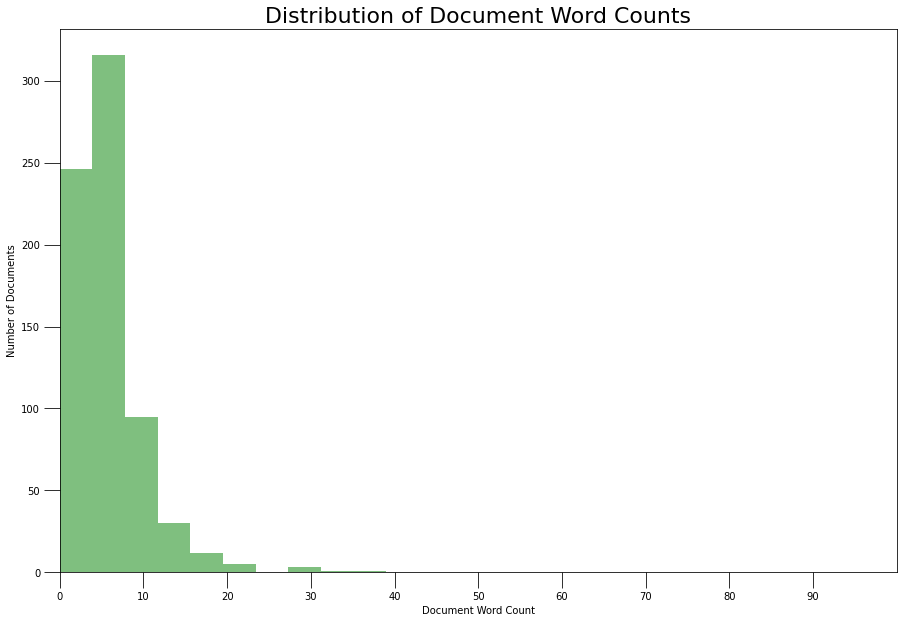

In [42]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(15,10))
plt.hist(doc_lens, color='green',  alpha = 0.5)
# plt.text(90, 100, "Mean   : " + str(round(np.mean(doc_lens))))
# plt.text(90,  90, "Median : " + str(round(np.median(doc_lens))))
# plt.text(90,  80, "Stdev   : " + str(round(np.std(doc_lens))))
# plt.text(90,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
# plt.text(90,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(range(0,100,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

# 11. Distribution of Document Word Counts by Dominant Topic

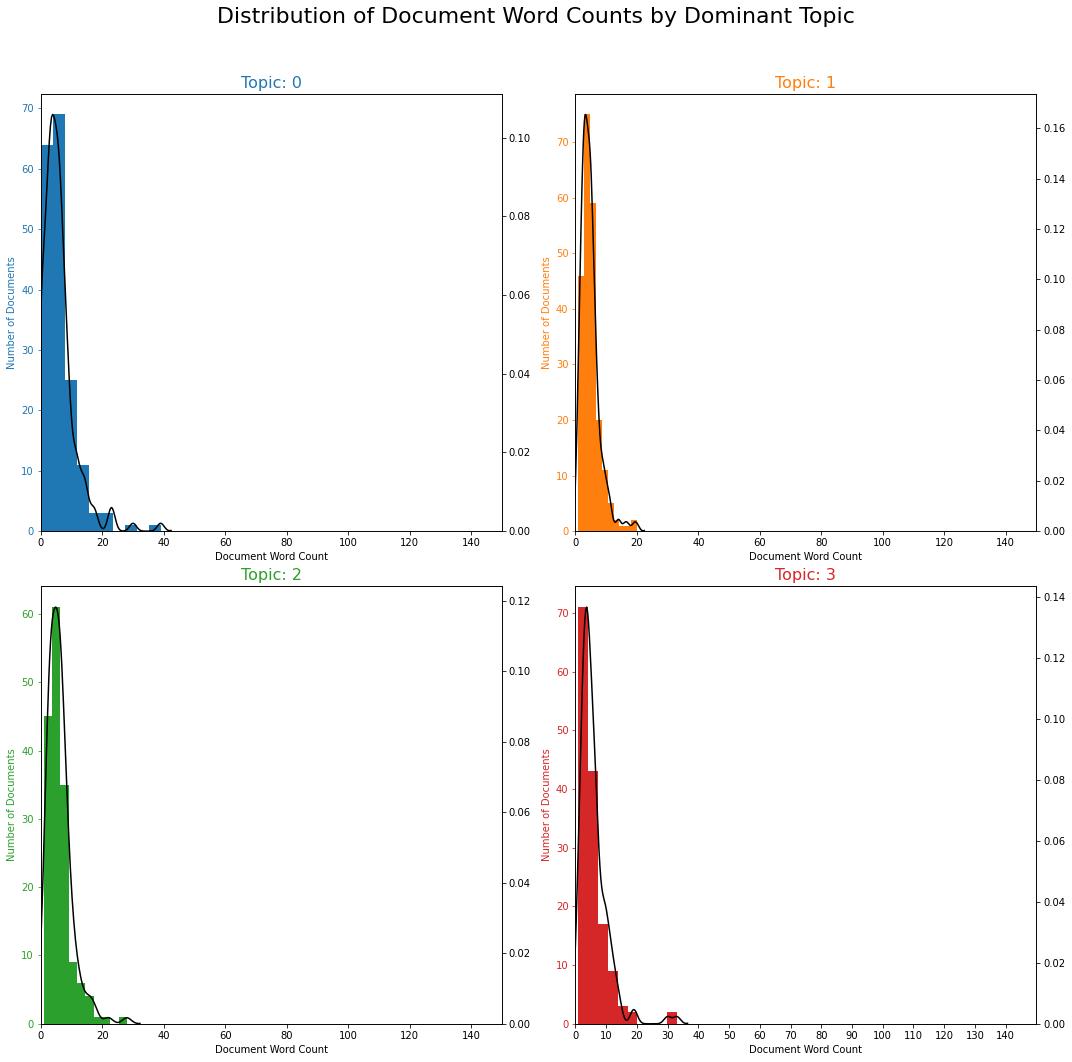

In [43]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(15,15), sharex=False, sharey=False)
#fig.delaxes(axes[2][1])
for i, ax in enumerate(axes.flatten()): 
    #if i in range(5):
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlim=(0, 150), xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(range(0,150,10))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# 12. Word Clouds of Top N Keywords in Each Topic

Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

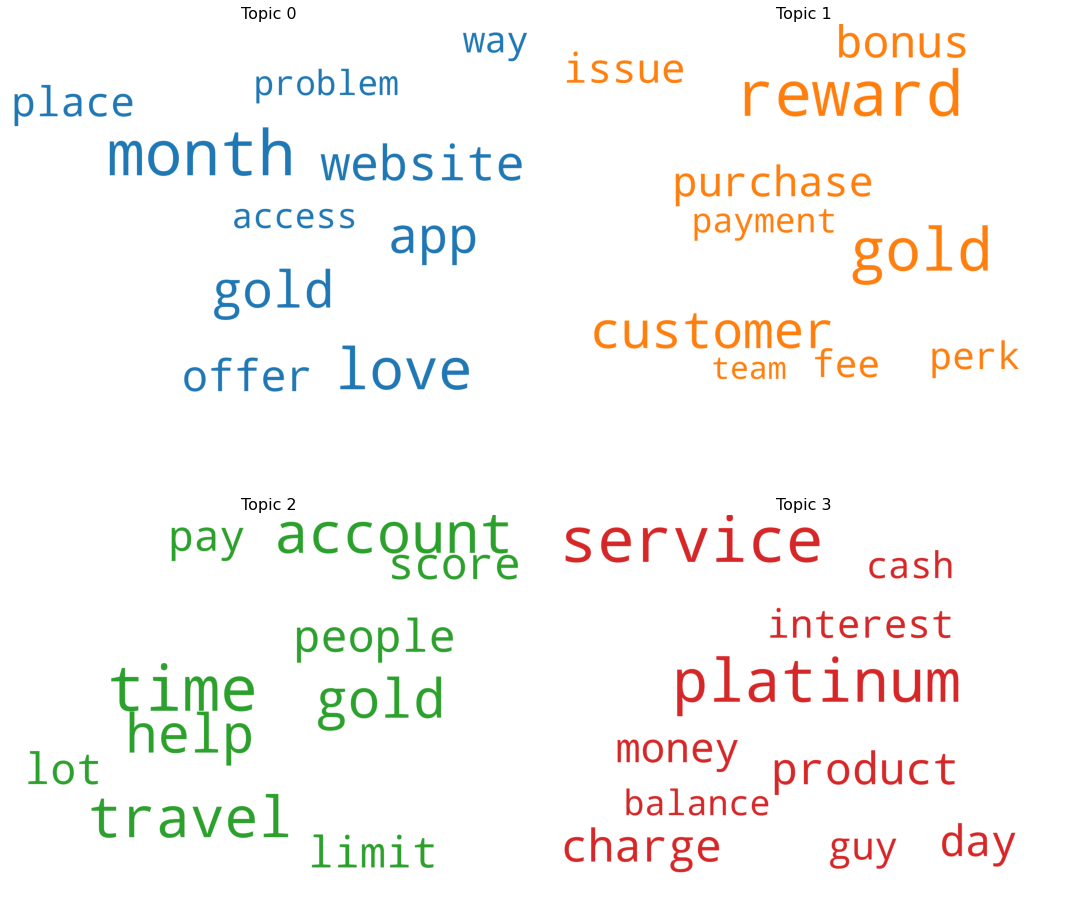

In [44]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)
#fig.delaxes(axes[2][1])
for i, ax in enumerate(axes.flatten()):
    #if i != 5:        
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [45]:
#topics

# 13. Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

**You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important.** The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.



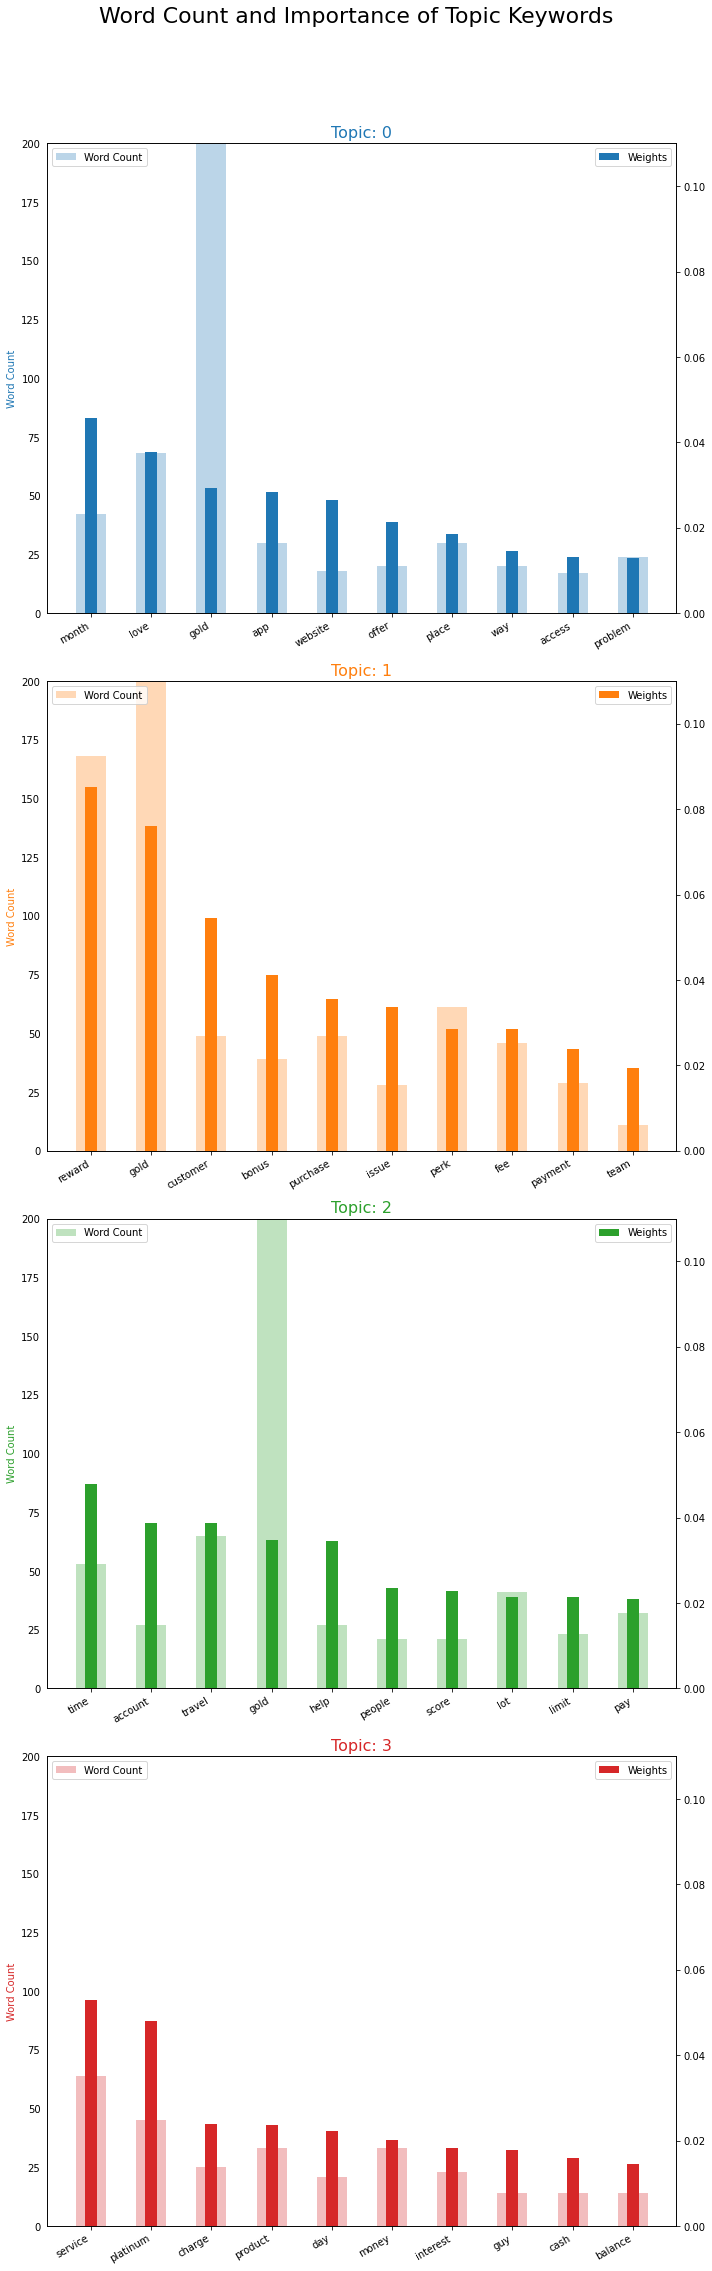

In [46]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 1, figsize=(10,30), sharey=True)
#fig.delaxes(axes[2][1])
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    #if i !=5 :
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.11); ax.set_ylim(0, 200)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# 14. Sentence Chart Colored by Topic

Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

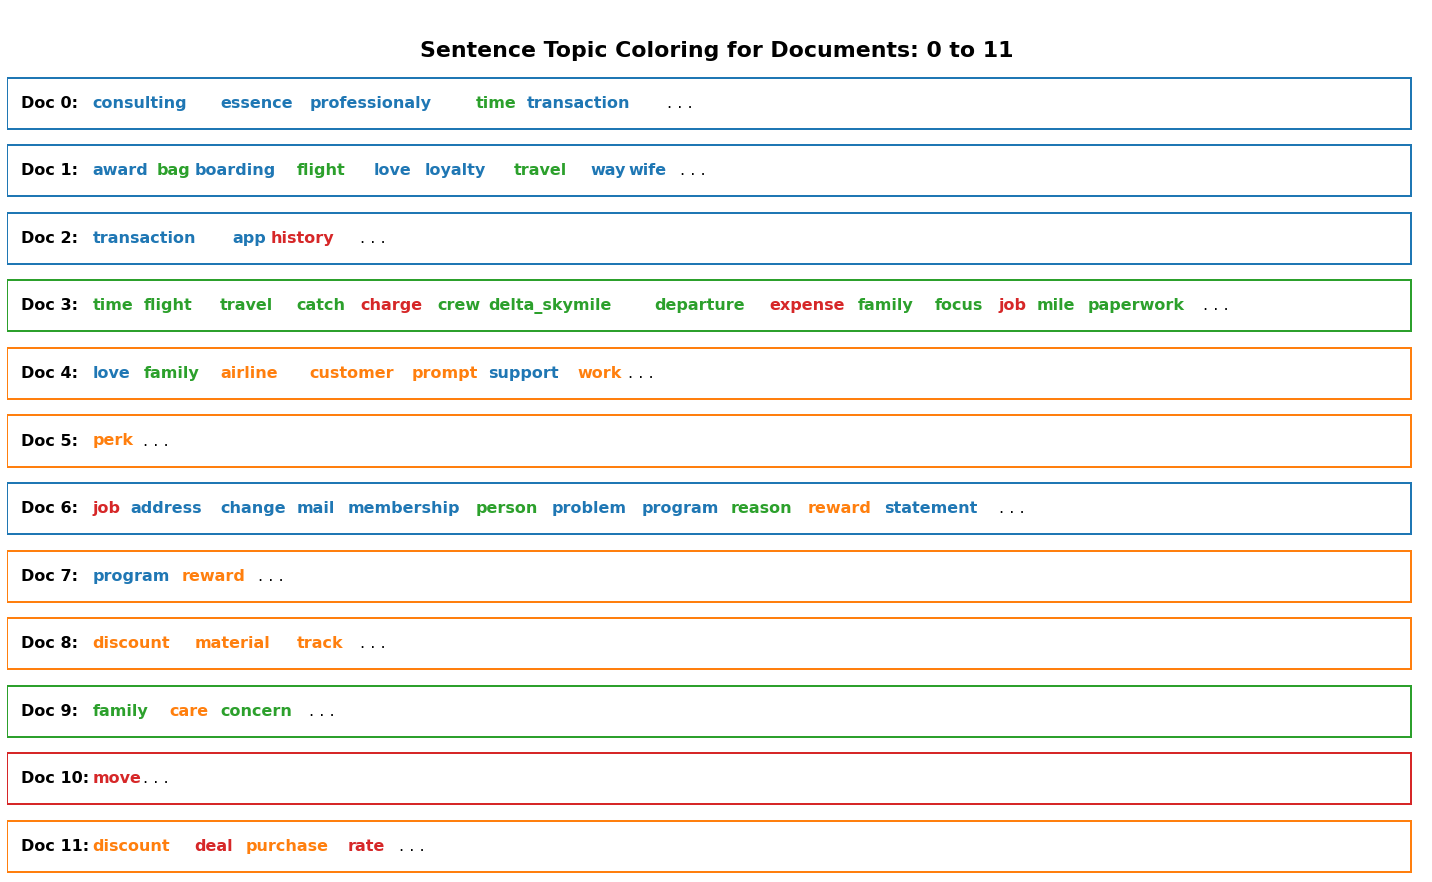

In [47]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95))       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    


# 15. What are the most discussed topics in the documents?

In [48]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


In [49]:
#topic_percentages

Let’s make two plots:

* The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
* The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

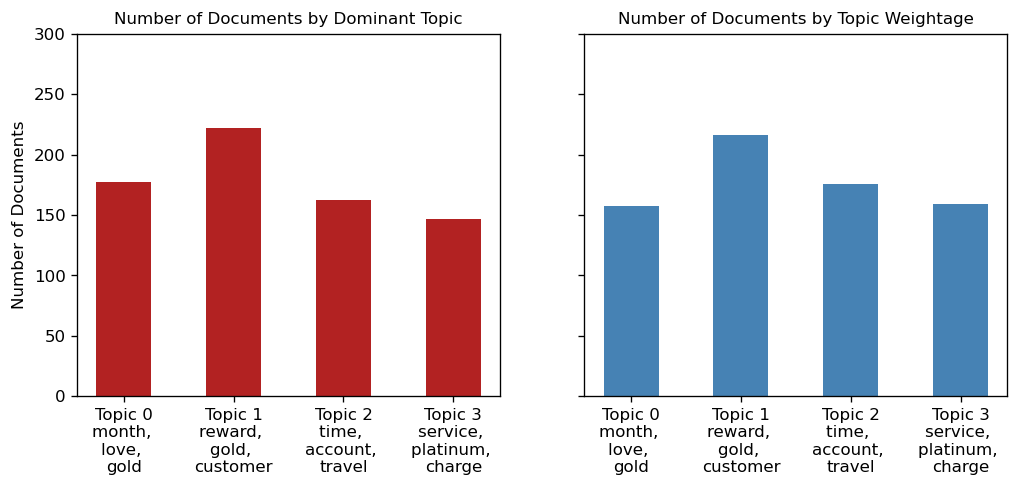

In [50]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 300)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [51]:
df_dominant_topic['Dominant_Topic'].value_counts()

1.0    222
0.0    177
2.0    163
3.0    147
Name: Dominant_Topic, dtype: int64

In [52]:
#topic_percentages

In [53]:
#df_topic_weightage_by_doc

In [54]:
#topic_weightage_by_doc.sum()

# 16. t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [55]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 677 samples in 0.000s...
[t-SNE] Computed neighbors for 677 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 677 / 677
[t-SNE] Mean sigma: 0.081237
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.532734
[t-SNE] KL divergence after 1000 iterations: 0.387061


Loading BokehJS ...

# 17. pyLDAVis
Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel().

In [56]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\deepa\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.175688  0.122403       1        1  28.198597
2     -0.077301 -0.255814       2        1  25.460779
0     -0.019143  0.118703       3        1  23.562004
3      0.272132  0.014707       4        1  22.778622, topic_info=    Category       Freq        Term      Total  loglift  logprob
53   Default  95.000000      reward  95.000000  30.0000  30.0000
40   Default  61.000000    customer  61.000000  29.0000  29.0000
34   Default  48.000000     service  48.000000  28.0000  28.0000
3    Default  48.000000        time  48.000000  27.0000  27.0000
87   Default  43.000000    platinum  43.000000  26.0000  26.0000
..       ...        ...         ...        ...      ...      ...
299   Topic4   5.829183  cardholder   6.485540   1.3726  -5.0400
24    Topic4   5.441498         job   6.069095   1.3702  -5.1088
516   Topic4   5.438848         sak   6.080167   1.3679  -5.1093
281   Topic4   5.447825       spend   6.096767   1.3668  -5.1077
247   Topic4   5.870864      market   6.577503   1.3657  -5.0329

[158 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
300       3  0.939443           access
153       2  0.986354          account
45        3  0.846695          address
39        1  0.968349          airline
884       4  0.914131  americanexpress
...     ...       ...              ...
348       3  0.903140             week
668       3  0.904077          weekend
901       1  0.901492          winning
43        1  0.971053             work
201       2  0.896353            world

[129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

### 15. Conclusion
We started from scratch by importing, cleaning and processing the dataset to build the LDA model. Then we saw multiple ways to visualize the outputs of topic models including the word clouds and sentence coloring, which intuitively tells you what topic is dominant in each topic. A t-SNE clustering and the pyLDAVis are provide more details into the clustering of the topics.